In [79]:
#importazione del df
import pandas as pd
df = pd.read_csv('csv/decessi_tot.csv')
df.head()

,Data,Totale
0,2015-01-01,2632
1,2015-01-02,2182
2,2015-01-03,2215
3,2015-01-04,2264
4,2015-01-05,2301


In [80]:
#trasformo le date e i numeri
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df.Totale = pd.to_numeric(df.Totale)
df.head()

,Data,Totale
0,2015-01-01,2632
1,2015-01-02,2182
2,2015-01-03,2215
3,2015-01-04,2264
4,2015-01-05,2301


In [81]:
#metto il campo 'Data' come indice
df=df.set_index('Data')
df.head()

,Totale
Data,
2015-01-01,2632
2015-01-02,2182
2015-01-03,2215
2015-01-04,2264
2015-01-05,2301


In [82]:
#creo la time series
ts = df.Totale
ts

Data
2015-01-01    2632
2015-01-02    2182
2015-01-03    2215
2015-01-04    2264
2015-01-05    2301
              ... 
2020-04-26    1735
2020-04-27    1752
2020-04-28    1702
2020-04-29    1664
2020-04-30    1539
Name: Totale, Length: 1947, dtype: int64

In [83]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,4,30)
lim_ts = ts[start_date:end_date]

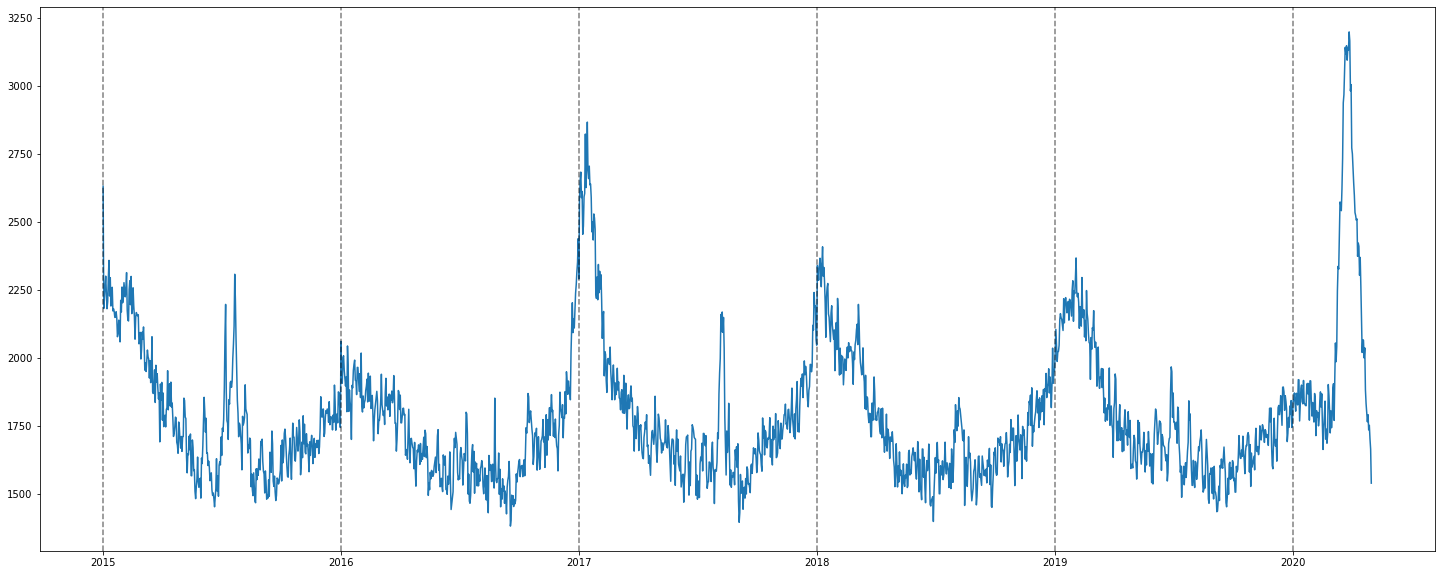

In [84]:
#visulizzo il grafico della time series
import matplotlib.pyplot as plt
plt.figure(figsize=(25,10))
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

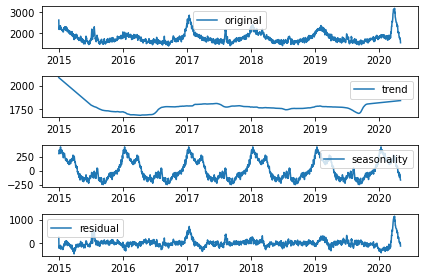

In [85]:
#decomposizione della serie in trend, stagionalità e residui
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=365, two_sided=True, extrapolate_trend=1, model='additive')

ts_trend = decomposition.trend #andamento della curva
ts_seasonal = decomposition.seasonal #stagionalità 
ts_residual = decomposition.resid #parti rimanenti
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

In [86]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
    else:
        print("X is not stationary")

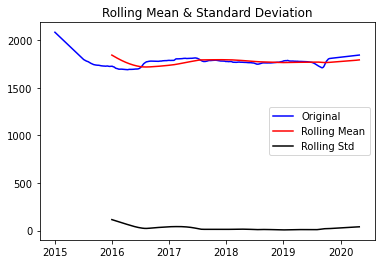

Results of Dickey-Fuller Test:
Test Statistic                  -21.896883
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1946.000000
Critical Value (1%)              -3.433715
Critical Value (5%)              -2.863026
Critical Value (10%)             -2.567561
dtype: float64
X is stationary


In [87]:
#verifico che il trend sia stazionario
test_stationarity(ts_trend.dropna())

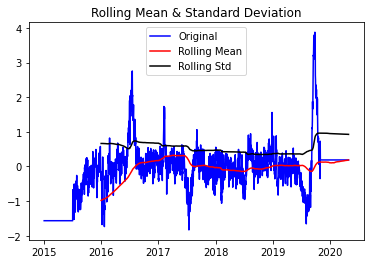

Results of Dickey-Fuller Test:
Test Statistic                   -4.979763
p-value                           0.000024
#Lags Used                       22.000000
Number of Observations Used    1923.000000
Critical Value (1%)              -3.433755
Critical Value (5%)              -2.863044
Critical Value (10%)             -2.567571
dtype: float64
X is stationary


In [88]:
#rendo il trend stazionario con l'operazione di differenzazione
ts_trend_diff = ts_trend.diff()
test_stationarity(ts_trend_diff.dropna())

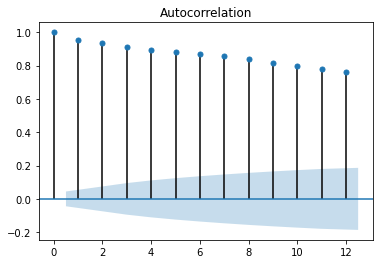

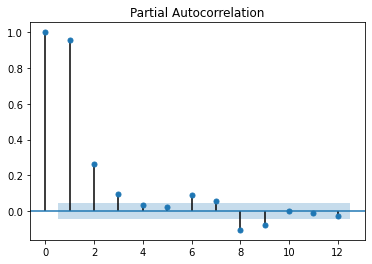

In [89]:
#grafici di autocorrelazione e autocorrelazione parziale
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts, lags =12)
plot_pacf(ts, lags =12)
plt.show()

In [90]:
#suddivisione del trend della serie in train e test
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)
covid_end = datetime(2020,4,30)

train = ts_trend[:train_end]
test = ts_trend[train_end + timedelta(days=1): test_end]

#trend COVID?
trend_covid = ts_trend[test_end + timedelta(days=1): covid_end]

#print(len(train))
#print(len(test))
#ts_trend
#print(len(covid))


In [91]:
train

Data
2015-01-01    2082.515068
2015-01-02    2080.950685
2015-01-03    2079.386301
2015-01-04    2077.821918
2015-01-05    2076.257534
                 ...     
2019-10-27    1807.487671
2019-10-28    1807.904110
2019-10-29    1808.158904
2019-10-30    1808.347945
2019-10-31    1807.997260
Name: trend, Length: 1765, dtype: float64

In [92]:
#creazione del modello
from statsmodels.tsa.statespace.sarimax import SARIMAX

#p = 12
#d = 1
#q = 9

model = SARIMAX(train, order=(0,1,9), seasonal_order=(2,1,1,12))
model_fit = model.fit(disp=1,solver='powell')
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                       
Dep. Variable:                                trend   No. Observations:                 1765
Model:             SARIMAX(0, 1, 9)x(2, 1, [1], 12)   Log Likelihood                -290.185
Date:                              Fri, 18 Sep 2020   AIC                            606.371
Time:                                      11:29:10   BIC                            677.461
Sample:                                  01-01-2015   HQIC                           632.649
                                       - 10-31-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7136      0.021     34.174      0.000       0.673       0.755
ma.L2          0.69

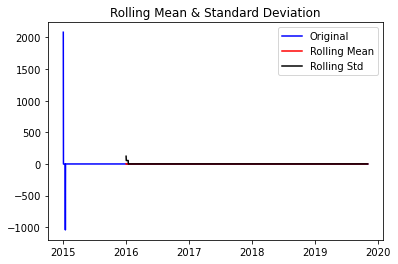

Results of Dickey-Fuller Test:
Test Statistic                 -806.182365
p-value                           0.000000
#Lags Used                       12.000000
Number of Observations Used    1752.000000
Critical Value (1%)              -3.434088
Critical Value (5%)              -2.863191
Critical Value (10%)             -2.567649
dtype: float64
X is stationary


In [93]:
#verifico che i residui della serie siano stazionari
residuals = model_fit.resid
test_stationarity(residuals)

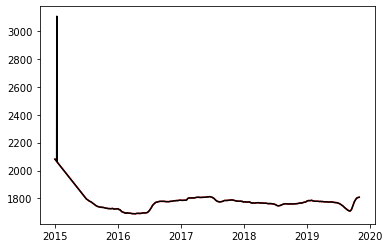

In [94]:
#verifico che il risultato del modello sul train
plt.plot(train.iloc[1:], color='red')
plt.plot(model_fit.fittedvalues.iloc[1:],color='black')
plt.show()

In [95]:
model_fit.fittedvalues #valori del modello 

Data
2015-01-01       0.000000
2015-01-02    2082.515491
2015-01-03    2080.951053
2015-01-04    2079.386602
2015-01-05    2077.822140
                 ...     
2019-10-27    1807.189564
2019-10-28    1807.862610
2019-10-29    1808.238450
2019-10-30    1808.416728
2019-10-31    1808.692515
Length: 1765, dtype: float64

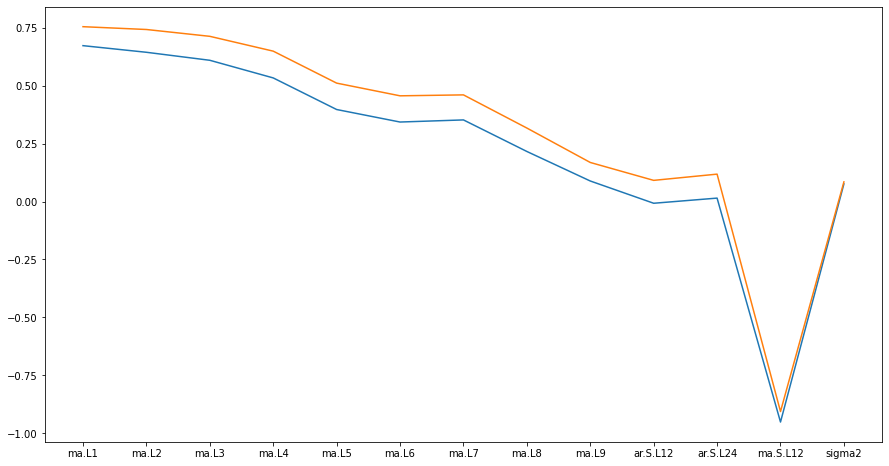

In [96]:
#Intervallo di confidenza del modello
conf = model_fit.conf_int()
plt.figure(figsize=(15,8))
plt.plot(conf)
plt.show()

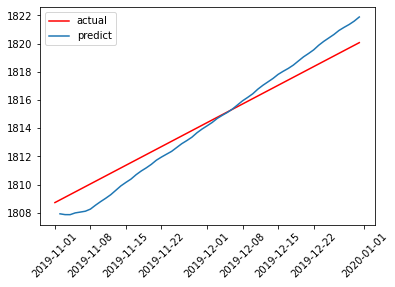

In [97]:
# predizioni sul test set
predictions = model_fit.forecast(steps=len(test))
plt.plot(test, color='red', label='actual')
plt.plot(predictions.iloc[1:], label='predict')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [98]:
#calcolo RMSE
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions, test)/(np.max(test)-np.min(test))
print('RMSE = ', nrmse)

RMSE =  0.09586844439147381


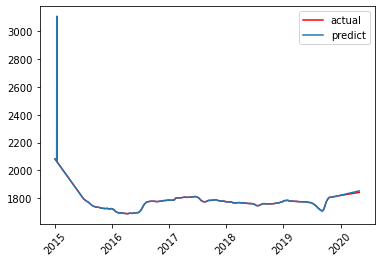

In [99]:
# predizione sul trend della serie storica includendo il 2020
predictions_trend = model_fit.predict(start=0, end=len(ts_trend.iloc[:-1]))
plt.plot(ts_trend, color='red', label='actual')
plt.plot(predictions_trend.iloc[1:], label='predict')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [100]:
ts_trend

Data
2015-01-01    2082.515068
2015-01-02    2080.950685
2015-01-03    2079.386301
2015-01-04    2077.821918
2015-01-05    2076.257534
                 ...     
2020-04-26    1842.186301
2020-04-27    1842.375342
2020-04-28    1842.564384
2020-04-29    1842.753425
2020-04-30    1842.942466
Name: trend, Length: 1947, dtype: float64

In [101]:
covid_predictions = predictions_trend.iloc[1826:] #valori della previsione del periodo covid (dal 01-01-2020 al 30-04-2020)

In [102]:
covid_predictions

2020-01-01    1822.179846
2020-01-02    1822.420515
2020-01-03    1822.677413
2020-01-04    1823.007003
2020-01-05    1823.285097
                 ...     
2020-04-26    1852.414630
2020-04-27    1852.617351
2020-04-28    1852.856219
2020-04-29    1853.150427
2020-04-30    1853.441444
Freq: D, Length: 121, dtype: float64

In [103]:
trend_covid

Data
2020-01-01    1820.257534
2020-01-02    1820.446575
2020-01-03    1820.635616
2020-01-04    1820.824658
2020-01-05    1821.013699
                 ...     
2020-04-26    1842.186301
2020-04-27    1842.375342
2020-04-28    1842.564384
2020-04-29    1842.753425
2020-04-30    1842.942466
Name: trend, Length: 121, dtype: float64

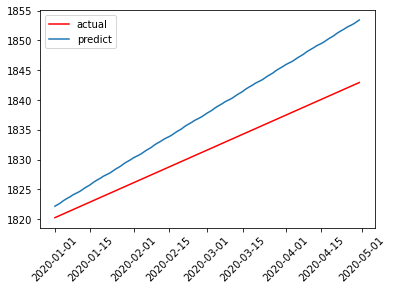

In [104]:
#previsione periodo covid
plt.plot(trend_covid, label='actual', color='red')
plt.plot(covid_predictions, label='predict')
plt.xticks(rotation=45)
plt.legend()
plt.show()

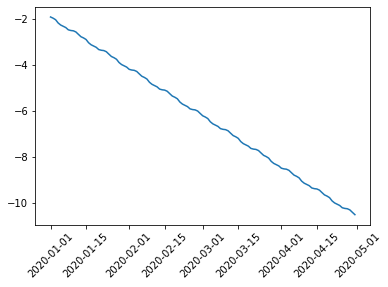

In [105]:
#calcolo della differenza tra i valori reali del covid e la previsione (periodo di riferimento 01-01-2020 - 30-04-2020)
trend_covid_diff = (trend_covid - covid_predictions)
trend_covid = trend_covid_diff.dropna()
plt.plot(trend_covid_diff)
plt.xticks(rotation=45)
plt.show()

In [106]:
trend_covid_diff #differenza tra i valori del trend_covid e la previsione

Data
2020-01-01    -1.922311
2020-01-02    -1.973940
2020-01-03    -2.041796
2020-01-04    -2.182345
2020-01-05    -2.271398
                ...    
2020-04-26   -10.228329
2020-04-27   -10.242009
2020-04-28   -10.291835
2020-04-29   -10.397002
2020-04-30   -10.498978
Length: 121, dtype: float64

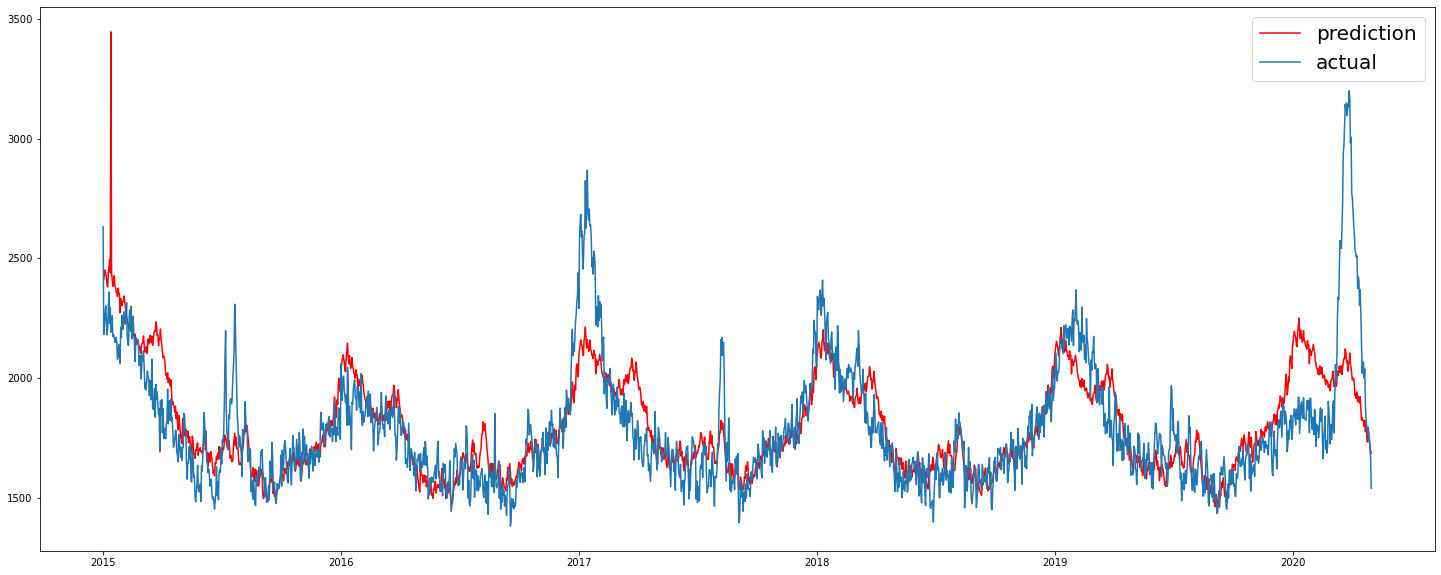

In [107]:
predictions_tot = predictions_trend.iloc[1:] + ts_seasonal
plt.figure(figsize=(25,10))
plt.plot(predictions_tot, color='red', label='prediction')
plt.plot(ts, label='actual')
plt.legend(prop={'size': 20})
plt.show()

In [108]:
# predictions_tot.conf_int()

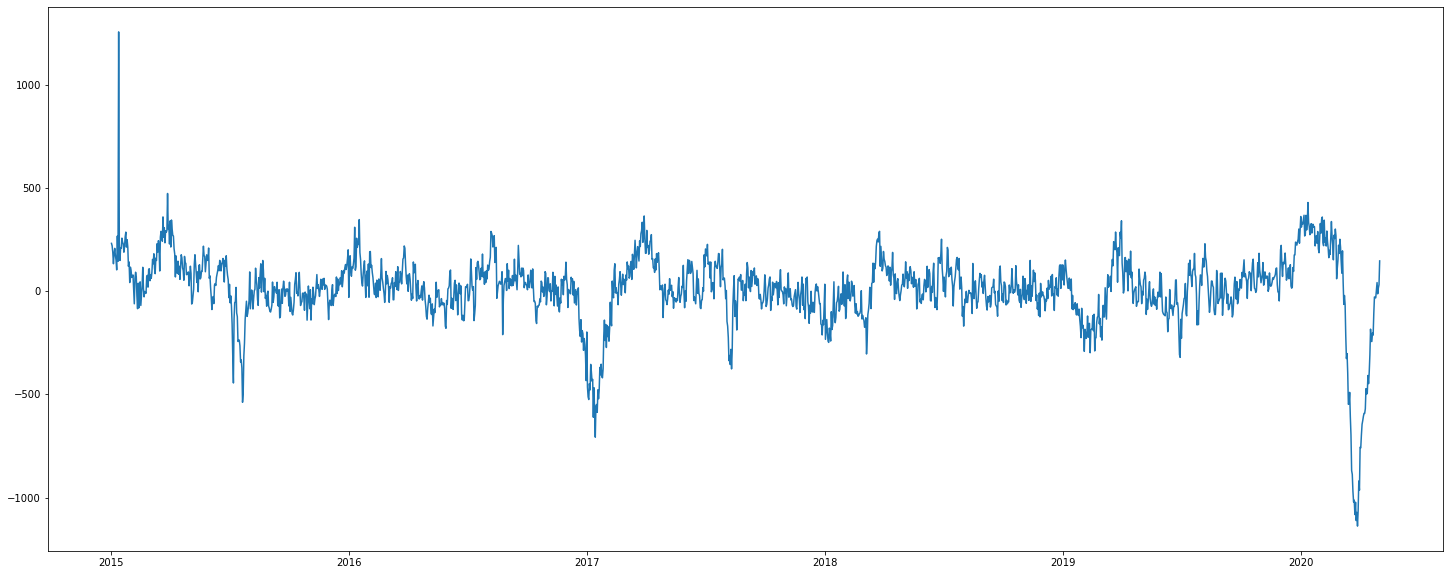

In [109]:
diff_predictions_tot = (predictions_tot - ts)
plt.figure(figsize=(25,10))
plt.plot(diff_predictions_tot)
plt.show()

In [110]:
predictions_tot.to_csv('csv/predictions_daily2.csv')